In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.patheffects as PathEffects
import pickle

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.tree import _tree, DecisionTreeClassifier
from IPython.display import display, HTML
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Data Generation   
This table includes the important features for AKI stages prediction and the corresponding AKI stages labels. 

In [3]:
# Load the dataset
df = pd.read_csv("Raw_aki_patient_data.csv")
# And get a peek of the first five lines of it
df.head()

,creat,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage,ANIONGAP_min,ANIONGAP_max,ALBUMIN_min,ALBUMIN_max,BANDS_min,...,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
0,NaN,1.8030,1.2149,1.2727,0,11.0,14.0,NaN,NaN,NaN,...,19.578475,36.722221,39.444444,37.829806,12.0,100.0,98.679558,97.0,123.0,108.500000
1,NaN,0.1437,0.1646,0.1782,3,15.0,20.0,1.9,2.6,8.0,...,23.348624,35.722222,38.833333,37.454106,70.0,100.0,93.792683,94.0,243.0,142.714286
2,NaN,1.0916,0.8270,0.7497,0,19.0,27.0,3.0,3.5,NaN,...,34.680000,37.444445,38.333333,37.896825,18.0,100.0,90.266667,42.0,270.0,133.769231
3,0.9,NaN,NaN,NaN,1,10.0,24.0,3.2,3.9,NaN,...,21.883721,36.111111,39.055557,37.166667,56.0,100.0,96.131579,74.0,208.0,128.380000
4,NaN,15.6182,15.6182,15.6182,0,NaN,NaN,NaN,NaN,NaN,...,14.750000,35.722222,35.722222,35.722222,43.0,100.0,94.300000,NaN,NaN,NaN


In [4]:
df.shape

(56093, 67)

In [5]:
# Get a peek of the features
print(list(df.columns))

['creat', 'uo_rt_6hr', 'uo_rt_12hr', 'uo_rt_24hr', 'aki_stage', 'ANIONGAP_min', 'ANIONGAP_max', 'ALBUMIN_min', 'ALBUMIN_max', 'BANDS_min', 'BANDS_max', 'BICARBONATE_min', 'BICARBONATE_max', 'BILIRUBIN_min', 'BILIRUBIN_max', 'CREATININE_min', 'CREATININE_max', 'CHLORIDE_min', 'CHLORIDE_max', 'GLUCOSE_min', 'GLUCOSE_max', 'HEMATOCRIT_min', 'HEMATOCRIT_max', 'HEMOGLOBIN_min', 'HEMOGLOBIN_max', 'LACTATE_min', 'LACTATE_max', 'PLATELET_min', 'PLATELET_max', 'POTASSIUM_min', 'POTASSIUM_max', 'PTT_min', 'PTT_max', 'INR_min', 'INR_max', 'PT_min', 'PT_max', 'SODIUM_min', 'SODIUM_max', 'BUN_min', 'BUN_max', 'WBC_min', 'WBC_max', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min_1', 'Glucose_Max_1', 'Glucose_Mean']


## Data Preprocessing

In [6]:
# Take look at percenatge of missing values per feature(column)
per_missing = df.isnull().sum()*100/len(df)
per_missing_df = pd.DataFrame(
    {"Feature Name": df.columns,
     "Missing Percentage": per_missing}
)
# Sort the percentage in a descending order
per_missing_df.sort_values(ascending=False, by="Missing Percentage", inplace=True)
per_missing_df

,Feature Name,Missing Percentage
BANDS_min,BANDS_min,81.926444
BANDS_max,BANDS_max,81.926444
uo_rt_12hr,uo_rt_12hr,68.288378
uo_rt_24hr,uo_rt_24hr,68.288378
uo_rt_6hr,uo_rt_6hr,68.288378
...,...,...
HEMATOCRIT_min,HEMATOCRIT_min,0.825415
HeartRate_Max,HeartRate_Max,0.224627
HeartRate_Min,HeartRate_Min,0.224627
HeartRate_Mean,HeartRate_Mean,0.224627


In [7]:
per_missing_df["Missing Percentage"].values

array([81.92644358, 81.92644358, 68.28837823, 68.28837823, 68.28837823,
       51.95122386, 51.95122386, 41.70395593, 41.70395593, 39.77501649,
       39.77501649, 32.9720286 , 12.63080955, 12.63080955, 12.33487244,
       12.33487244, 12.32952418, 12.32952418,  6.91886688,  6.91886688,
        6.91886688,  6.71028471,  6.71028471,  6.71028471,  6.68532615,
        6.68532615,  6.68532615,  6.65501934,  6.65501934,  6.65501934,
        6.65323659,  6.65323659,  6.65323659,  6.64254007,  6.64254007,
        6.64254007,  6.46604746,  6.46604746,  6.46604746,  6.18793789,
        6.18793789,  5.69411513,  5.69411513,  5.69411513,  5.69411513,
        2.41384843,  2.41384843,  2.37106234,  2.37106234,  2.11434582,
        2.11434582,  2.08225625,  2.08225625,  2.03590466,  2.03590466,
        1.04112813,  1.04112813,  1.03221436,  1.03221436,  1.00012479,
        1.00012479,  0.82541494,  0.82541494,  0.22462696,  0.22462696,
        0.22462696,  0.        ])

In [8]:
per_missing_df.at["BANDS_min", "Missing Percentage"]

81.92644358476102

In [9]:
dftype = pd.DataFrame(df.dtypes, columns=['pd_type'])
dftype['n_unique'] = df.nunique()
dftype['nan_bool'] = df.isna().any()
dftype['n_nan'] = df.isna().sum()
dftype

,pd_type,n_unique,nan_bool,n_nan
creat,float64,153,True,18495
uo_rt_6hr,float64,11397,True,38305
uo_rt_12hr,float64,11884,True,38305
uo_rt_24hr,float64,12390,True,38305
aki_stage,int64,4,False,0
...,...,...,...,...
SpO2_Max,float64,36,True,3764
SpO2_Mean,float64,29910,True,3764
Glucose_Min_1,float64,376,True,3627
Glucose_Max_1,float64,857,True,3627


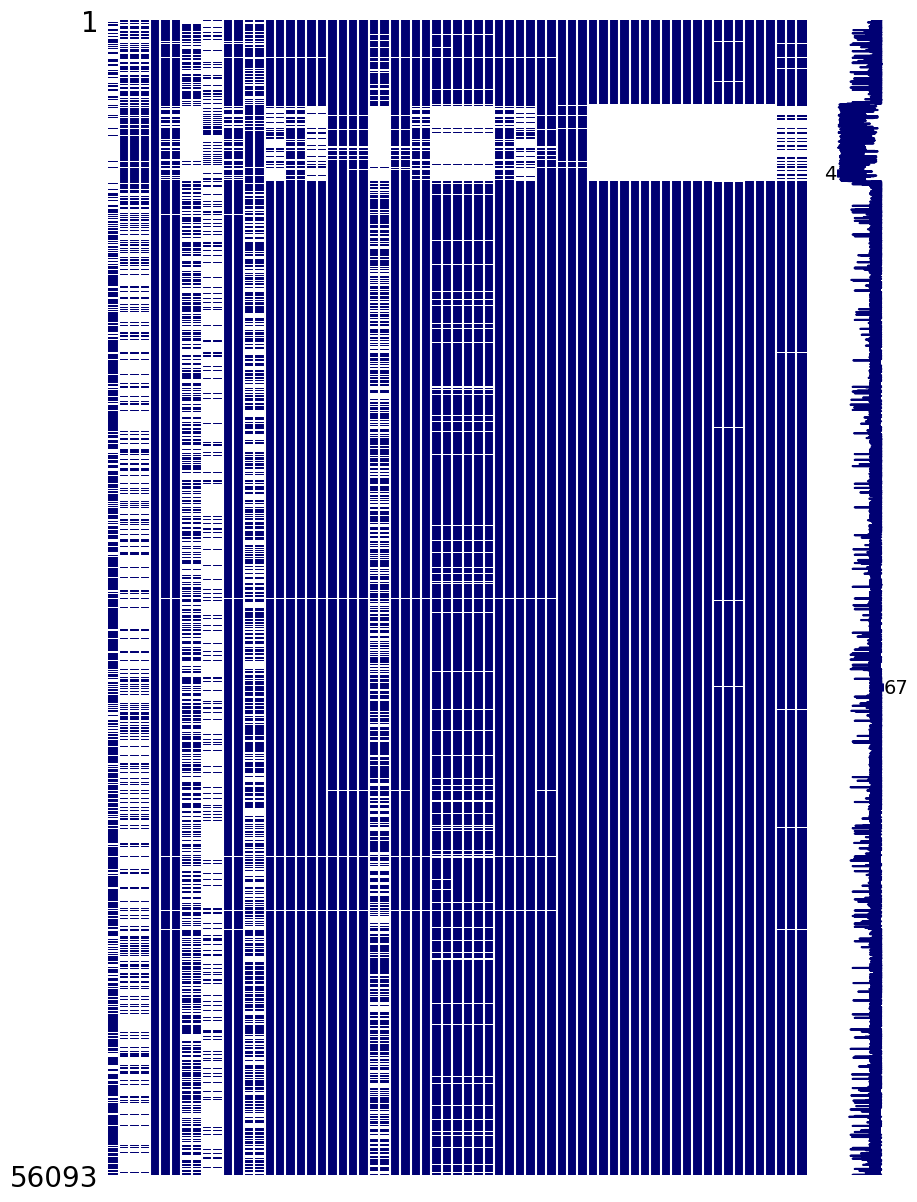

In [10]:
# Visualize missing values as a matrix
import missingno as msno
#X_all = df.drop(columns=['aki_stage'])
msno.matrix(df, color=(0., 0., 0.45))   
fig = plt.gcf()
fig.set_size_inches(10, 15)

In [11]:
# Drop the feature if the missing percenatge is greater than 40 percent
for feature in per_missing_df["Feature Name"].values:
  if per_missing_df.at[feature, "Missing Percentage"] >= 40:
    df.drop([feature], inplace=True, axis=1)
print(df.columns)

Index(['creat', 'aki_stage', 'ANIONGAP_min', 'ANIONGAP_max', 'BICARBONATE_min',
       'BICARBONATE_max', 'CREATININE_min', 'CREATININE_max', 'CHLORIDE_min',
       'CHLORIDE_max', 'GLUCOSE_min', 'GLUCOSE_max', 'HEMATOCRIT_min',
       'HEMATOCRIT_max', 'HEMOGLOBIN_min', 'HEMOGLOBIN_max', 'LACTATE_min',
       'LACTATE_max', 'PLATELET_min', 'PLATELET_max', 'POTASSIUM_min',
       'POTASSIUM_max', 'PTT_min', 'PTT_max', 'INR_min', 'INR_max', 'PT_min',
       'PT_max', 'SODIUM_min', 'SODIUM_max', 'BUN_min', 'BUN_max', 'WBC_min',
       'WBC_max', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean',
       'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
       'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min_1', 'Glucose_Max_1', 'Glucose_Mean'],
      dtype='object')


In [12]:
df.head()

,creat,aki_stage,ANIONGAP_min,ANIONGAP_max,BICARBONATE_min,BICARBONATE_max,CREATININE_min,CREATININE_max,CHLORIDE_min,CHLORIDE_max,...,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
0,NaN,0,11.0,14.0,30.0,32.0,0.6,0.8,99.0,106.0,...,19.578475,36.722221,39.444444,37.829806,12.0,100.0,98.679558,97.0,123.0,108.500000
1,NaN,3,15.0,20.0,12.0,21.0,1.0,1.6,97.0,105.0,...,23.348624,35.722222,38.833333,37.454106,70.0,100.0,93.792683,94.0,243.0,142.714286
2,NaN,0,19.0,27.0,11.0,19.0,1.3,2.0,107.0,111.0,...,34.680000,37.444445,38.333333,37.896825,18.0,100.0,90.266667,42.0,270.0,133.769231
3,0.9,1,10.0,24.0,18.0,30.0,0.6,1.6,96.0,108.0,...,21.883721,36.111111,39.055557,37.166667,56.0,100.0,96.131579,74.0,208.0,128.380000
4,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,113.0,113.0,...,14.750000,35.722222,35.722222,35.722222,43.0,100.0,94.300000,NaN,NaN,NaN


### Interpolation of missing data

Since we don't have any prior knowledge about the distribution of these data, one way for interpolation is to fill all the NAs with mean value of that column.

In [13]:
for feature in df.columns:
  # Calculate the mean values of each column ignoring nas
  mean_value = df[feature].mean(skipna=True)
  # Interpolate the missing value with the mean value
  df[feature].fillna(value=mean_value, inplace=True)

# Peek the dataset
df.head()

,creat,aki_stage,ANIONGAP_min,ANIONGAP_max,BICARBONATE_min,BICARBONATE_max,CREATININE_min,CREATININE_max,CHLORIDE_min,CHLORIDE_max,...,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
0,1.342936,0,11.000000,14.000000,30.000000,32.00000,0.6,0.8,99.0,106.0,...,19.578475,36.722221,39.444444,37.829806,12.0,100.0,98.679558,97.000000,123.000000,108.500000
1,1.342936,3,15.000000,20.000000,12.000000,21.00000,1.0,1.6,97.0,105.0,...,23.348624,35.722222,38.833333,37.454106,70.0,100.0,93.792683,94.000000,243.000000,142.714286
2,1.342936,0,19.000000,27.000000,11.000000,19.00000,1.3,2.0,107.0,111.0,...,34.680000,37.444445,38.333333,37.896825,18.0,100.0,90.266667,42.000000,270.000000,133.769231
3,0.900000,1,10.000000,24.000000,18.000000,30.00000,0.6,1.6,96.0,108.0,...,21.883721,36.111111,39.055557,37.166667,56.0,100.0,96.131579,74.000000,208.000000,128.380000
4,1.342936,0,11.226164,16.918395,21.665044,28.04884,1.0,1.0,113.0,113.0,...,14.750000,35.722222,35.722222,35.722222,43.0,100.0,94.300000,95.057013,239.531548,137.017814


In [14]:
#As we can see that the all the NAs have gone
df.isnull().values.any()

False

In [15]:
# Let's take a look at the summary of this dataset
df.describe()

,creat,aki_stage,ANIONGAP_min,ANIONGAP_max,BICARBONATE_min,BICARBONATE_max,CREATININE_min,CREATININE_max,CHLORIDE_min,CHLORIDE_max,...,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min_1,Glucose_Max_1,Glucose_Mean
count,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,...,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000,56093.000000
mean,1.342936,0.310342,11.226164,16.918395,21.665044,28.048840,1.095230,1.753217,99.981574,108.503743,...,19.083222,35.852295,37.717340,36.830278,87.983899,99.704848,96.879729,95.057013,239.531548,137.017814
std,1.217599,0.781658,3.105499,4.602545,4.665786,4.568863,1.056676,1.952617,5.693187,5.840850,...,3.539276,0.769855,0.809219,0.540202,11.542212,1.077874,2.346509,31.113892,5970.922590,154.523360
min,0.000000,0.000000,1.000000,4.000000,2.000000,5.000000,0.050000,0.100000,1.600000,74.000000,...,7.333333,15.000000,30.000000,30.000000,0.500000,42.000000,31.444444,0.106000,1.000000,1.000000
25%,0.800000,0.000000,9.000000,14.000000,19.000000,25.000000,0.600000,0.900000,97.000000,105.000000,...,16.644444,35.555556,37.166668,36.518056,87.983899,100.000000,96.129032,78.000000,141.000000,113.757143
50%,1.200000,0.000000,11.000000,16.000000,22.000000,28.000000,0.800000,1.200000,100.000000,108.000000,...,18.935484,35.852295,37.700000,36.830278,91.000000,100.000000,97.041667,94.000000,183.000000,130.714286
75%,1.342936,0.000000,13.000000,19.000000,24.000000,30.000000,1.100000,1.753217,103.000000,112.000000,...,20.943820,36.277779,38.166665,37.133333,94.000000,100.000000,98.153846,107.000000,239.531548,148.500000
max,20.100000,3.000000,45.000000,77.000000,52.000000,60.000000,19.100000,138.000000,134.000000,198.000000,...,43.777778,40.833333,46.500000,40.833333,100.000000,100.000000,100.000000,798.000000,999999.000000,32392.483871


### Rebalancing the class distribution

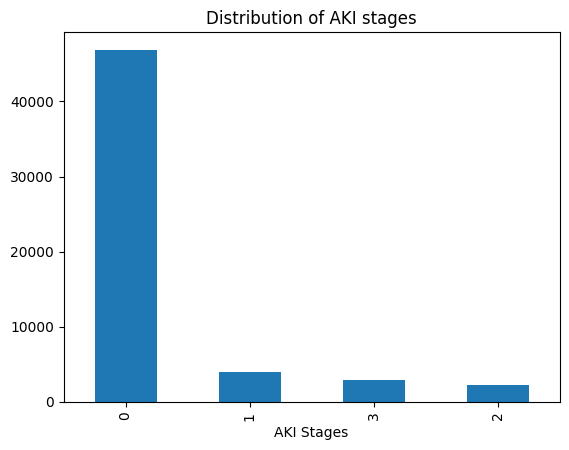

In [16]:
df["aki_stage"].value_counts().plot.bar()
plt.title("Distribution of AKI stages")
plt.xlabel("AKI Stages")
plt.show()

In [17]:
# We can observe that our dataset is extremly umbalanaced with too many class 0
# This may cause overfitting, so we want to some of class 0
df["aki_stage"].value_counts()

aki_stage
0    46867
1     3995
3     2951
2     2280
Name: count, dtype: int64

In [18]:
# Only keep 10 percent of the original class 0
df = df.drop(df[df['aki_stage'] == 0].sample(frac=.9).index)
print(df["aki_stage"].value_counts())

aki_stage
0    4687
1    3995
3    2951
2    2280
Name: count, dtype: int64


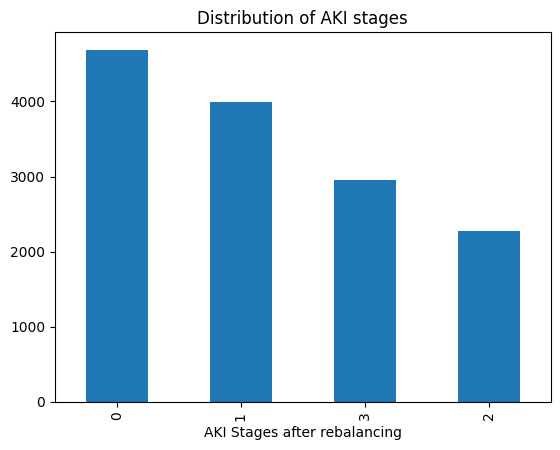

In [19]:
df["aki_stage"].value_counts().plot.bar()
plt.title("Distribution of AKI stages")
plt.xlabel("AKI Stages after rebalancing")
plt.show()
# We can see that the class distribution is much balance now

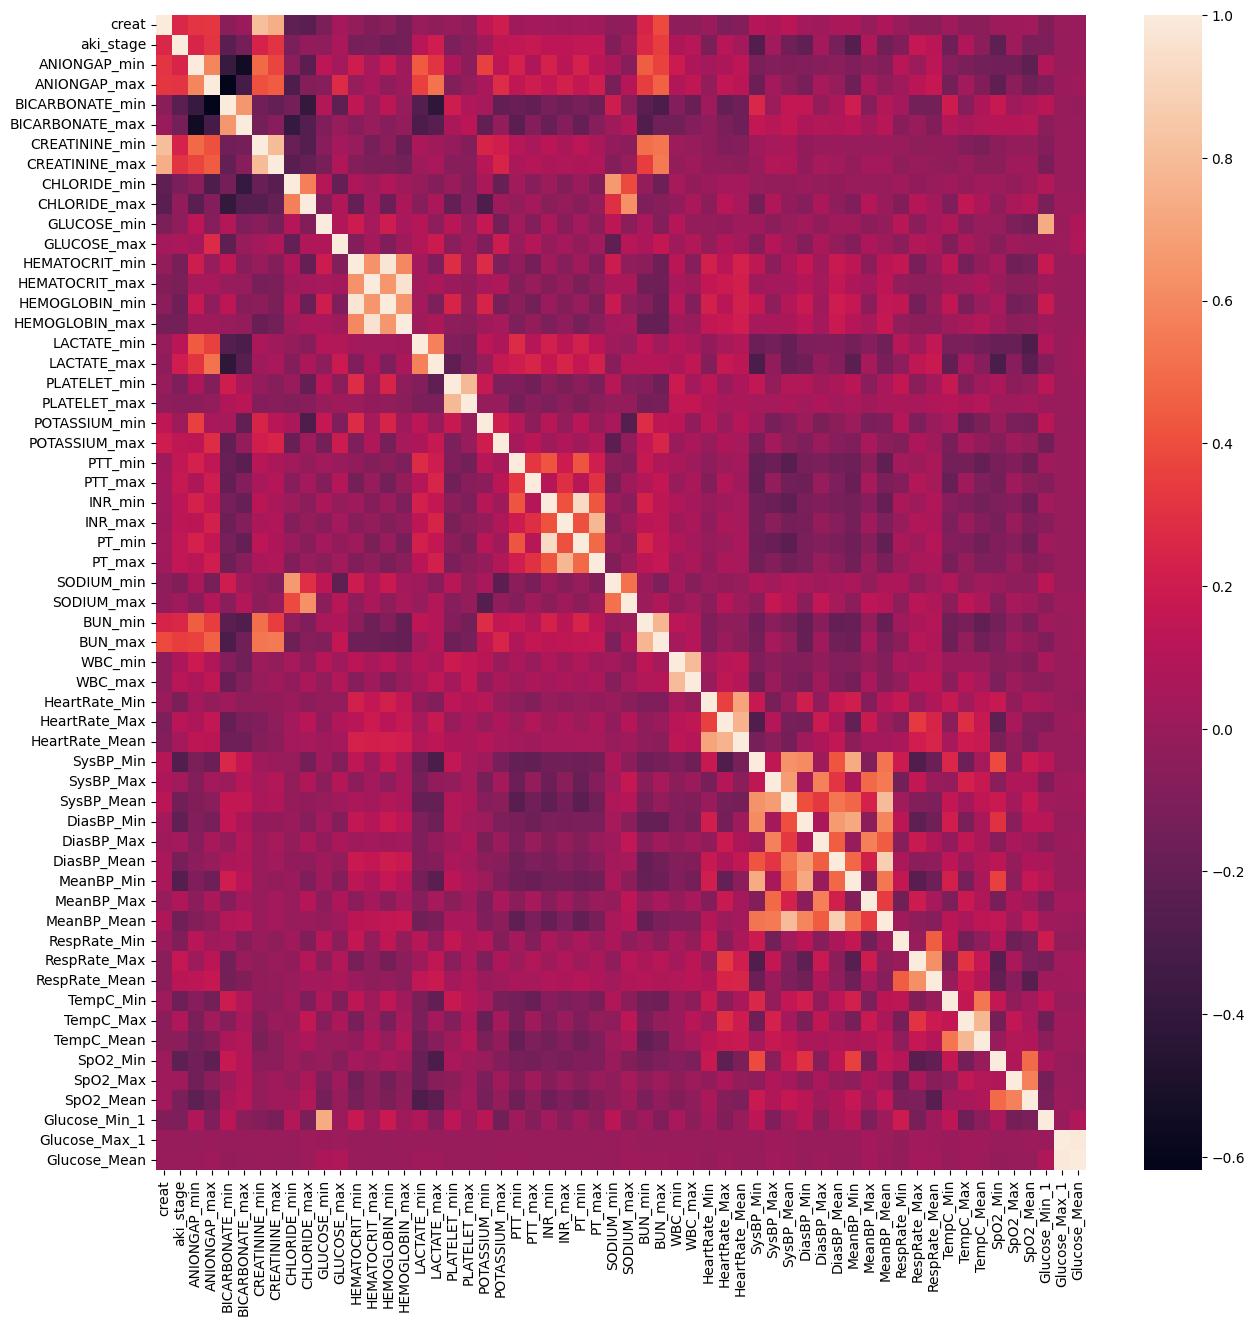

In [20]:
# Let's take a look at the correlation matrix
import seaborn as sns
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr())
plt.show()

### Train Test Split

For this part, we want to split our dataset into train and test dataset.

In [21]:
# First split into features and labels
df_y = df["aki_stage"]
df_X = df.drop(["aki_stage"], axis=1)
# Turn the dataframes into numpy arrays for further calulation
y = df_y.to_numpy()
X= df_X.to_numpy()

In [22]:
print(X.shape, "\n", y.shape)

(13913, 57) 
 (13913,)


In [23]:
# Train test split
# 30% would be a good percenatge for testing our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=2021)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9739, 57) (4174, 57) (9739,) (4174,)


### Standarization

The range of different feature values varies a lot. We need to standardize them after the train test plit incase of leakage of information.

In [24]:
# Train Data Scaler
train_scaler = preprocessing.StandardScaler().fit(X_train)
# mean, scale
print("means:", "\n", train_scaler.mean_)
print("scales:", "\n", train_scaler.scale_)

means: 
 [  1.86222255  11.84328308  18.20650029  20.77588888  27.76943938
   1.44064925   2.53325011  99.16228883 108.40635604  90.64428778
 210.58620813  27.5312269   36.50405434   9.25128784  12.12057628
   1.68240681   3.49873084 172.41517088 276.40095278   3.53702041
   5.10775934  30.21187541  57.1030705    1.2843789    2.06644855
  14.24325765  19.67036841 134.49704884 142.04280641  22.92724651
  42.55079535   8.619112    16.01295612  66.85281397 115.70920533
  88.0029857   82.26782699 159.17664967 118.63548029  37.34602692
  92.36676885  59.6221895   50.5282724  117.82682716  77.20202083
  10.66075363  31.2481127   19.43456108  35.71611512  37.75501858
  36.7888696   85.69081348  99.74084676  96.67963572  91.63413376
 318.87000225 141.81149907]
scales: 
 [1.87856386e+00 3.64619456e+00 5.48993558e+00 5.16142316e+00
 5.02979787e+00 1.46684777e+00 3.01104867e+00 5.96234897e+00
 6.34204760e+00 3.13081960e+01 1.22224155e+02 6.83067427e+00
 5.85839554e+00 2.31640927e+00 2.03347097e+0

In [25]:
# Fit
X_train = train_scaler.transform(X_train)

In [26]:
print(X_train.std(axis=0))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [27]:
# Train Data Scaler
test_scaler = preprocessing.StandardScaler().fit(X_test)
# Fit
X_test = test_scaler.transform(X_test)

Now we are ready to train our models with our preprocessed dataset

## Unsupervised Clustering

Let's first try to visualize our high dimensional data, here I have tried two different method PCA and tSNE

In [28]:
time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X_test)

print("PCA done! Time elapsed {} seconds".format(time.time() - time_start))

PCA done! Time elapsed 0.37979626655578613 seconds


In [29]:
# Check the PCA components
pca_df = pd.DataFrame(columns=["PCA1", "PCA2", "PCA3", "PCA4"])

for i in range(4):
  pca_df["PCA{}".format(i+1)] = pca_result[:, i]

print("Variance explained per principle component: {}".format(pca.explained_variance_ratio_))
print(pca_df)

Variance explained per principle component: [0.12049205 0.07827583 0.07401987 0.07173597]
          PCA1      PCA2      PCA3      PCA4
0    -1.738686 -0.024605 -1.350712  0.270892
1    -1.000231  0.980156  1.528735  0.954145
2     3.140050  0.813278 -0.503173 -4.194347
3    -0.855551 -1.764559  1.969305 -4.176986
4     0.776033 -1.672684  0.162208 -0.779046
...        ...       ...       ...       ...
4169  1.833263 -0.888423 -0.754376 -1.666902
4170 -2.051990  1.882355  0.353223 -0.969080
4171 -0.209952 -3.398573 -0.276814  0.318790
4172  7.788367  1.917169  5.730989  1.861786
4173 -2.334818  1.110413  2.440673 -1.287900

[4174 rows x 4 columns]


In [30]:
# Utility function to visualize the outputs of PCA and t-SNE

def grouping_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts 

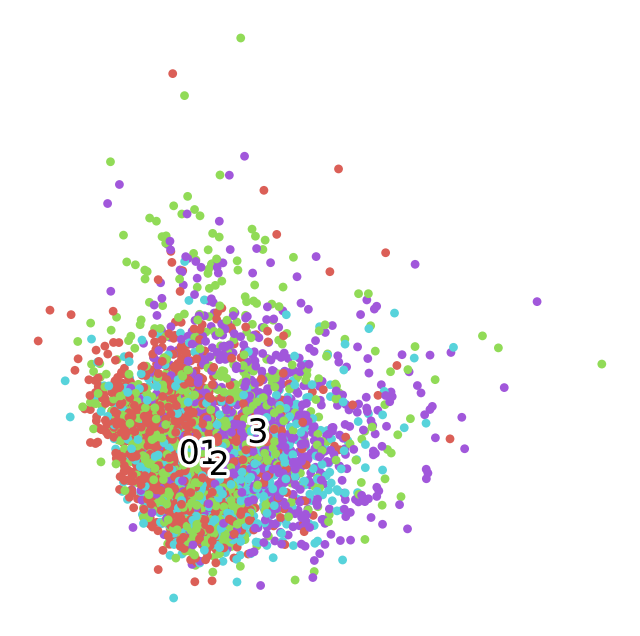

In [31]:
# Visualize the first two components
top_two_comp = pca_df[["PCA1", "PCA2"]]

grouping_scatter(top_two_comp.values, y_test)
plt.show()

We can see that the first two PCA components cannot explain the variance, and we cannot tell the difference of the groups. Let's try tSNE now.

In [32]:
# Before the tSNE first use the PCA
time_start = time.time()

pca_20 = PCA(n_components=20)
pca_result_20 = pca_20.fit_transform(X_test)

print("PCA with 20 components done! Time elapsed: {} seconds".format(time.time() - time_start))
print("cuculative variance exlained by 20 principle components: {}".format(np.sum(pca_20.explained_variance_ratio_)))

PCA with 20 components done! Time elapsed: 0.12492251396179199 seconds
cuculative variance exlained by 20 principle components: 0.8186753147477288


In [33]:
time_start = time.time()

pca_20_tsne = TSNE(random_state=2021).fit_transform(pca_result_20)
print("t-SNE done! Time elapsed: {} seconds".format(time.time()-time_start))

t-SNE done! Time elapsed: 21.99475646018982 seconds


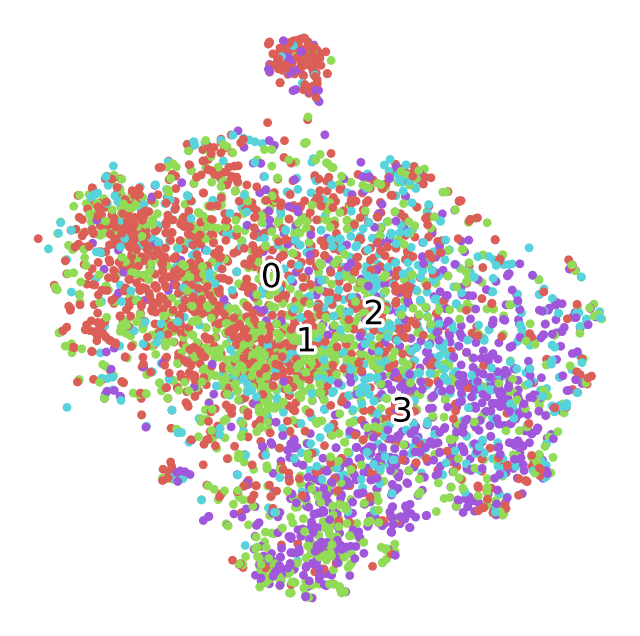

In [34]:
# Visualize the tSNE
grouping_scatter(pca_20_tsne, y_test)
plt.show()

From the tSNE we can see that the stage 0 and stage 3 are clearly seperated while stage 2 and stage 1 are mixed together.  
We can anticipate that our clustering results may not be good.

In [35]:
#Install + Imports
!pip install -q sweetviz
import sweetviz as sv

RAW_PATH = "/kaggle/input/aki-patient-data/Raw_aki_patient_data.csv"
df_raw = pd.read_csv(RAW_PATH)
df_raw.shape, df_raw.dtypes.head(10)

((56093, 67),
 creat           float64
 uo_rt_6hr       float64
 uo_rt_12hr      float64
 uo_rt_24hr      float64
 aki_stage         int64
 ANIONGAP_min    float64
 ANIONGAP_max    float64
 ALBUMIN_min     float64
 ALBUMIN_max     float64
 BANDS_min       float64
 dtype: object)

In [37]:
# B1 — Sweetviz (multiclass target, force numeric)
from sweetviz import FeatureConfig

# ensure numeric dtype (in case it was read as object)
df_raw["aki_stage"] = pd.to_numeric(df_raw["aki_stage"], errors="coerce")

fc = FeatureConfig(force_num=["aki_stage"])
sv_report = sv.analyze(df_raw, target_feat="aki_stage", feat_cfg=fc)
sv_report.show_html("Sweetviz_Report.html", open_browser=False)
print("Saved Sweetviz_Report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report Sweetviz_Report.html was generated.
Saved Sweetviz_Report.html


## KNN

In [35]:
# Imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [36]:
# Build pipeline + hyperparameter grid
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11, 15],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["euclidean", "manhattan"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro"
}

grid_knn = GridSearchCV(
    estimator=knn_pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1_macro",        # choose the model with the best macro-F1
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': [3, 5, 7, 9, 11, 15],
                         'knn__weights': ['uniform', 'distance']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': 'precision_macro',
                      'recall_macro': 'recall_macro'},
             verbose=1)

In [37]:
# Cross-validation results & best params
print("Best params (by macro-F1):", grid_knn.best_params_)
print("Best CV scores:")
cv_row = grid_knn.cv_results_["mean_test_f1_macro"][grid_knn.best_index_]
print(f"  f1_macro: {grid_knn.best_score_:.4f}")
acc_row = grid_knn.cv_results_["mean_test_accuracy"][grid_knn.best_index_]
prec_row = grid_knn.cv_results_["mean_test_precision_macro"][grid_knn.best_index_]
rec_row = grid_knn.cv_results_["mean_test_recall_macro"][grid_knn.best_index_]
print(f"  accuracy: {acc_row:.4f} | precision_macro: {prec_row:.4f} | recall_macro: {rec_row:.4f}")

# (Optional) tidy CV table
cv_table = pd.DataFrame(grid_knn.cv_results_)[
    ["param_knn__n_neighbors","param_knn__weights","param_knn__metric",
     "mean_test_accuracy","mean_test_precision_macro","mean_test_recall_macro","mean_test_f1_macro",
     "rank_test_f1_macro"]
].sort_values("rank_test_f1_macro")
cv_table.head(10)

Best params (by macro-F1): {'knn__metric': 'manhattan', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
Best CV scores:
  f1_macro: 0.4206
  accuracy: 0.4714 | precision_macro: 0.4552 | recall_macro: 0.4241


,param_knn__n_neighbors,param_knn__weights,param_knn__metric,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro,rank_test_f1_macro
23,15,distance,manhattan,0.471403,0.455170,0.424122,0.420574,1
11,15,distance,euclidean,0.465241,0.450871,0.419936,0.417498,2
21,11,distance,manhattan,0.467193,0.445390,0.420774,0.417443,3
19,9,distance,manhattan,0.460519,0.436665,0.416785,0.414960,4
9,11,distance,euclidean,0.457438,0.438120,0.414683,0.413168,5
22,15,uniform,manhattan,0.468117,0.460248,0.416295,0.411252,6
7,9,distance,euclidean,0.451688,0.429294,0.410535,0.409843,7
17,7,distance,manhattan,0.449120,0.427917,0.408588,0.408642,8
5,7,distance,euclidean,0.445528,0.426802,0.406832,0.408324,9
10,15,uniform,euclidean,0.460724,0.450410,0.409914,0.404984,10


In [38]:
# Test-set evaluation (multiple metrics)
y_pred_knn = grid_knn.predict(X_test)

print("Test metrics (overall):")
print(f"  accuracy        : {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"  precision_macro : {precision_score(y_test, y_pred_knn, average='macro', zero_division=0):.4f}")
print(f"  recall_macro    : {recall_score(y_test, y_pred_knn, average='macro', zero_division=0):.4f}")
print(f"  f1_macro        : {f1_score(y_test, y_pred_knn, average='macro', zero_division=0):.4f}")

print("\nClassification report (per class):")
print(classification_report(y_test, y_pred_knn, digits=4, zero_division=0))

Test metrics (overall):
  accuracy        : 0.4808
  precision_macro : 0.4505
  recall_macro    : 0.4282
  f1_macro        : 0.4196

Classification report (per class):
              precision    recall  f1-score   support

           0     0.4966    0.7201    0.5878      1415
           1     0.4211    0.4271    0.4241      1180
           2     0.2890    0.0910    0.1385       692
           3     0.5955    0.4746    0.5282       887

    accuracy                         0.4808      4174
   macro avg     0.4505    0.4282    0.4196      4174
weighted avg     0.4618    0.4808    0.4544      4174



Confusion matrix (rows=actual, cols=predicted):
 [[1019  307   49   40]
 [ 491  504   45  140]
 [ 353  170   63  106]
 [ 189  216   61  421]]


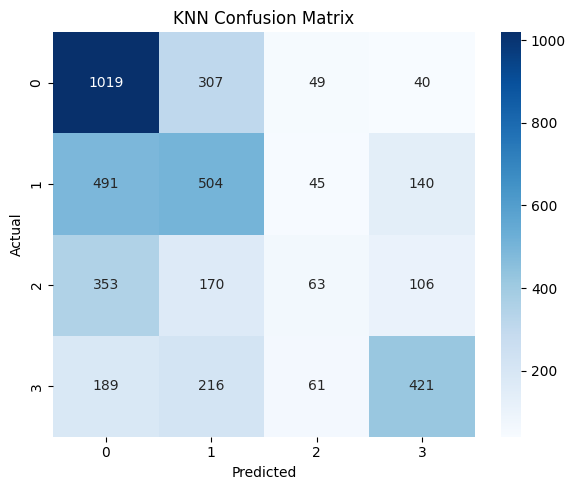

In [39]:
# Confusion matrix (numbers + heatmap)
cm = confusion_matrix(y_test, y_pred_knn, labels=[0,1,2,3])

print("Confusion matrix (rows=actual, cols=predicted):\n", cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.show()

## Gaussian NB

In [40]:
# Imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_score, recall_score)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
# Build pipeline + hyperparameter grid
gnb_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("gnb", GaussianNB())
])

param_grid_gnb = {
    "gnb__var_smoothing": np.logspace(-12, -6, 13)  # 1e-12 ... 1e-6
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

scoring = {
    "accuracy": "accuracy",
    "f1_macro": "f1_macro",
    "precision_macro": "precision_macro",
    "recall_macro": "recall_macro"
}

grid_gnb = GridSearchCV(
    estimator=gnb_pipe,
    param_grid=param_grid_gnb,
    scoring=scoring,
    refit="f1_macro",              # pick best by macro-F1
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_gnb.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gnb', GaussianNB())]),
             n_jobs=-1,
             param_grid={'gnb__var_smoothing': array([1.00000000e-12, 3.16227766e-12, 1.00000000e-11, 3.16227766e-11,
       1.00000000e-10, 3.16227766e-10, 1.00000000e-09, 3.16227766e-09,
       1.00000000e-08, 3.16227766e-08, 1.00000000e-07, 3.16227766e-07,
       1.00000000e-06])},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro',
                      'precision_macro': 'precision_macro',
                      'recall_macro': 'recall_macro'},
             verbose=1)

In [42]:
# Cross-validation results & best params
print("Best params (by macro-F1):", grid_gnb.best_params_)
print("Best CV scores:")
print(f"  f1_macro: {grid_gnb.best_score_:.4f}")
acc_row = grid_gnb.cv_results_["mean_test_accuracy"][grid_gnb.best_index_]
prec_row = grid_gnb.cv_results_["mean_test_precision_macro"][grid_gnb.best_index_]
rec_row = grid_gnb.cv_results_["mean_test_recall_macro"][grid_gnb.best_index_]
print(f"  accuracy: {acc_row:.4f} | precision_macro: {prec_row:.4f} | recall_macro: {rec_row:.4f}")

# (Optional) tidy CV table
cv_table_gnb = pd.DataFrame(grid_gnb.cv_results_)[
    ["param_gnb__var_smoothing",
     "mean_test_accuracy","mean_test_precision_macro","mean_test_recall_macro","mean_test_f1_macro",
     "rank_test_f1_macro"]
].sort_values("rank_test_f1_macro")
cv_table_gnb.head(10)

Best params (by macro-F1): {'gnb__var_smoothing': 3.162277660168379e-07}
Best CV scores:
  f1_macro: 0.3651
  accuracy: 0.3904 | precision_macro: 0.4409 | recall_macro: 0.3931


,param_gnb__var_smoothing,mean_test_accuracy,mean_test_precision_macro,mean_test_recall_macro,mean_test_f1_macro,rank_test_f1_macro
11,0.0,0.390395,0.440876,0.393078,0.365100,1
12,0.000001,0.390395,0.440876,0.393078,0.365100,1
0,0.0,0.390293,0.440533,0.392920,0.364975,3
1,0.0,0.390293,0.440533,0.392920,0.364975,3
2,0.0,0.390293,0.440533,0.392920,0.364975,3
3,0.0,0.390293,0.440533,0.392920,0.364975,3
4,0.0,0.390293,0.440533,0.392920,0.364975,3
5,0.0,0.390293,0.440533,0.392920,0.364975,3
6,0.0,0.390293,0.440533,0.392920,0.364975,3
7,0.0,0.390293,0.440533,0.392920,0.364975,3


In [43]:
# Test-set evaluation (multiple metrics)
y_pred_gnb = grid_gnb.predict(X_test)

print("Test metrics (overall):")
print(f"  accuracy        : {accuracy_score(y_test, y_pred_gnb):.4f}")
print(f"  precision_macro : {precision_score(y_test, y_pred_gnb, average='macro', zero_division=0):.4f}")
print(f"  recall_macro    : {recall_score(y_test, y_pred_gnb, average='macro', zero_division=0):.4f}")
print(f"  f1_macro        : {f1_score(y_test, y_pred_gnb, average='macro', zero_division=0):.4f}")

print("\nClassification report (per class):")
print(classification_report(y_test, y_pred_gnb, digits=4, zero_division=0))

Test metrics (overall):
  accuracy        : 0.3505
  precision_macro : 0.4267
  recall_macro    : 0.2657
  f1_macro        : 0.1657

Classification report (per class):
              precision    recall  f1-score   support

           0     0.3464    0.9830    0.5122      1415
           1     0.5000    0.0212    0.0407      1180
           2     0.4000    0.0260    0.0488       692
           3     0.4603    0.0327    0.0611       887

    accuracy                         0.3505      4174
   macro avg     0.4267    0.2657    0.1657      4174
weighted avg     0.4229    0.3505    0.2062      4174



Confusion matrix (rows=actual, cols=predicted):
 [[1391    9    9    6]
 [1134   25    5   16]
 [ 656    6   18   12]
 [ 835   10   13   29]]


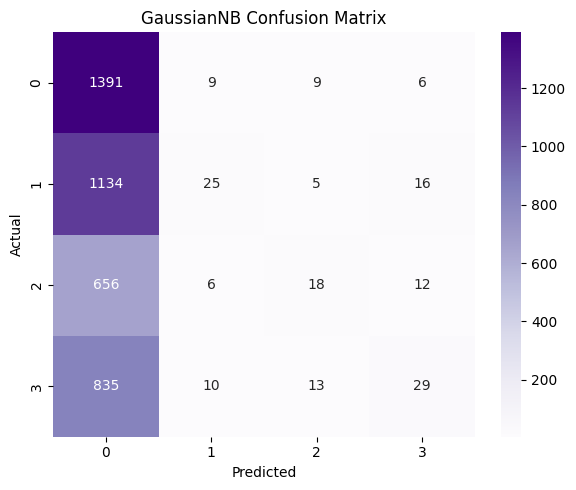

In [44]:
# Confusion matrix (numbers + heatmap)
cm_gnb = confusion_matrix(y_test, y_pred_gnb, labels=[0,1,2,3])

print("Confusion matrix (rows=actual, cols=predicted):\n", cm_gnb)

plt.figure(figsize=(6,5))
sns.heatmap(cm_gnb, annot=True, fmt="d", cmap="Purples",
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("GaussianNB Confusion Matrix")
plt.tight_layout()
plt.show()

## Unified results table

In [45]:
def collect_results(name, y_true, y_pred):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "Recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "F1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0)
    }

results = []
# assuming y_pred_knn from Section 4 and y_pred_gnb from Section 5
results.append(collect_results("KNN (tuned)", y_test, y_pred_knn))
results.append(collect_results("GaussianNB (tuned)", y_test, y_pred_gnb))

results_df = pd.DataFrame(results).sort_values("F1_macro", ascending=False).reset_index(drop=True)
results_df

,Model,Accuracy,Precision_macro,Recall_macro,F1_macro
0,KNN (tuned),0.480834,0.450526,0.428234,0.419646
1,GaussianNB (tuned),0.350503,0.426671,0.265733,0.165699
